# Similar Cards Module (SCM)

In this notebook we combine all previous knowledge to implement a class which enables us to propose to a given card similar cards. This is only a prototype version.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
import re
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.neighbors import NearestNeighbors

In [2]:
# read and outputs the mtg card db
def db_cards_init():
    columns = ['id','name','text','manaCost','manaValue','colorIdentity','colors','convertedManaCost','type','types','loyalty','power','toughness','keywords',
        'edhrecRank','life','defense','scryfallId','scryfallIllustrationId','scryfallOracleId','relatedCards']
    dtype = {'id': 'int64','name': str,'text': str,'manaCost': str,'manaValue': float,'colorIdentity': str,'colors': str,
            'convertedManaCost': float,'type': str,'types': str,'loyalty': 'object','power': 'object','toughness': 'object',
            'keywords': str,'edhrecRank': 'object','life': 'object','defense': 'object','scryfallId': str,'scryfallIllustrationId': str,
            'scryfallOracleId': str,'relatedCards': str }
    db = pd.read_csv('../data/mtg_cards_data/AllPrintingsCSVFiles/cards.csv',usecols = columns, dtype = dtype)
    return db

# manipulates a db: For each unique value in the given columns, a new column is created with entries 1 if the value is contained that row or 0 else
def vectorize_columns(db, columns):
    index = db.index
    df_list = []
    for col in columns:
        for val in db[col].dropna().str.split(',').explode().unique():
            df_list = df_list  + [ pd.DataFrame({val :[1 if x else 0 for x in db[col].str.contains(val, case=False)]},index = index)]
    db = pd.concat([db]+ df_list,axis=1)
    return db

# A given text is split into labeled subtexts
def effect_type_dist(text):
    txt_ser = pd.Series(text.split('\n'))
    
    act_eff = txt_ser[txt_ser.str.contains(':',regex=False)].to_list()
    txt_ser = txt_ser[~txt_ser.str.contains(':',regex=False)]
    
    tri_eff = txt_ser[txt_ser.str.contains(r'when |whenever |at |[^a-zA-Z]when |[^a-zA-Z]whenever |[^a-zA-Z]at ',case=False)].to_list()
    txt_ser = txt_ser[~txt_ser.str.contains(r'when |whenever |at |[^a-zA-Z]when |[^a-zA-Z]whenever |[^a-zA-Z]at ',case=False)]
    
    kyw_eff = txt_ser[~txt_ser.str.contains('.',regex=False)].to_list()
    
    stt_eff = txt_ser[txt_ser.str.contains('.',regex=False)].to_list()

    return (act_eff,tri_eff,kyw_eff,stt_eff)

def eff_columns(db):
    index = db.index
    db_txt = pd.DataFrame([effect_type_dist(txt) if txt else txt for txt in db.Text],columns=['activated_effects','trigger_effects','keywords_effects','static_effects'],index = index)
    return pd.concat([db,db_txt],axis=1)
    
def tokenizer(txt):
    if(txt):
        return ' '.join(' '.join(' '.join(' '.join(txt.split('.')).split(',')).split('(')).split(')')).split()
    return txt

def db_cards_proc(db):
    db = db.groupby('name',as_index=False).first()
    db['Text'] = db.apply(lambda x: re.sub(r'[\(].*[\)]', '',str(x['text']).replace(x['name'], 'this card').replace(x['name'].split(',')[0], 'this card')) if (x['text']) else x['text'],axis=1)
    db = vectorize_columns(db, ['colorIdentity','keywords','types'])
    db = eff_columns(db)
    db['TokText'] = db['activated_effects'] + db['trigger_effects'] + db['static_effects']
    db['TokText'] = db['TokText'].apply(lambda x: x if isinstance(x, list) else [])
    db['TokText'] = db['TokText'].apply(lambda x: [tokenizer(txt) if txt else txt for txt in x])
    for col in ['loyalty','power','toughness']:
        dic = {db[col].dropna().sort_values().unique()[i]: i for i in range(len(db[col].dropna().sort_values().unique()))}
        db[col] = db[col].map(dic).fillna(0)
    return db

def calc_sim(model_d2v,ab_list1,ab_list2):
    sim = []
    for ab1 in ab_list1:
        for ab2 in ab_list2:
            if(bool(ab1) and bool(ab2)):
                if(model_d2v.wv.n_similarity(ab1,ab2)> 0):
                    sim = sim + [model_d2v.wv.n_similarity(ab1,ab2)]
    return np.mean(sim)


In [3]:
class SCM:
    def __init__(self):
        self.cards = db_cards_proc(db_cards_init())
        self.card_ind = self.cards.index[np.random.randint(0,len(self.cards))]
        self.documents = [TaggedDocument(doc,[i]) for i,doc in enumerate(self.cards['TokText'].explode().dropna())]
        self.model_d2v = Doc2Vec(self.documents,vector_size=300,window=5,min_count=1,workers=4)
        
    def get_card(self):
        Im = Image.open(requests.get('https://api.scryfall.com/cards/' + self.cards.loc[self.card_ind,:].scryfallId + '/?format=image&version=small',stream=True).raw)
        display(Im)
        Im.close()
        return None
    
    def set_card(self, card_name: str = ''):
        if(bool(card_name)):
            self.card_ind = self.cards.index[self_cards['name'].str.contains(card_name, case=False)][0]
        else: 
            self.card_ind = self.cards.index[np.random.randint(0,len(self.cards))]
        return None
    
    def text_sim(self):
        self.cards['text_sim'] = self.cards['TokText'].apply(lambda txt_list: calc_sim(self.model_d2v,txt_list,self.cards.loc[self.card_ind,:].TokText) if txt_list else 0)    
        return None
    
    def get_sim_cards(self, txt_weight:float = 3, base_power_weight:float = 0, base_toughness_weight:float = 0,loyalty_weight:float = 0, keywords_weight:float = 0.5, color_weight:float = 0.5, type_weight:float = 1):
        weight = [txt_weight, base_power_weight,base_toughness_weight, loyalty_weight]
        col = ['text_sim','power','toughness','loyalty']
        dic_weight = {'keywords': keywords_weight,'colorIdentity': color_weight,'types': type_weight}
        for c in ['keywords','colorIdentity','types']:
            new_col = self.cards[c].dropna().str.split(',').explode().unique().tolist()
            col = col + new_col
            weight = weight + [dic_weight[c] for i in range(len(new_col))]
        if not ('text_sim' in self.cards.columns.to_list()):
            print('Please call text_sim() if you are interested in a Card Text dependent search')
            self.cards['text_sim'] = 0        
        db_train = self.cards[col].fillna(0)
        for c, weight in zip(col,weight):
            db_train[c] = db_train[c] * weight
        db_train = db_train.to_numpy()
        ngh = NearestNeighbors(n_neighbors=5)
        ngh.fit(db_train)
        dist, ind = ngh.kneighbors([self.cards.loc[self.card_ind,col].fillna(0).to_numpy()],n_neighbors=5)
        for i in ind[0]: 
            Im = Image.open(requests.get('https://api.scryfall.com/cards/' + self.cards.iloc[i,:].scryfallId + '/?format=image&version=small', stream=True).raw)
            display(Im)
            Im.close()

In [4]:
scm = SCM()

<ipython-input-2-fc0c6e8b8389>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  db['TokText'] = db['activated_effects'] + db['trigger_effects'] + db['static_effects']


In [5]:
scm.text_sim()

/home/joerg/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


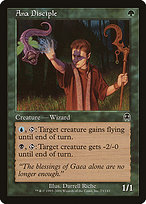

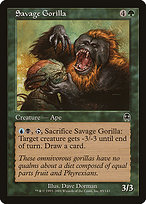

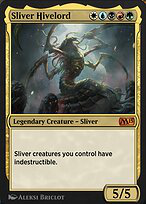

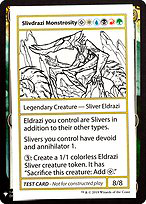

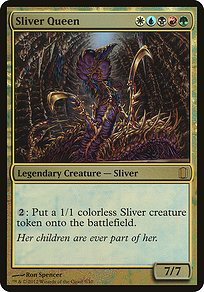

In [6]:
scm.get_sim_cards()

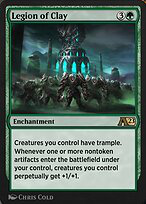

In [7]:
scm.set_card()
scm.get_card()

/home/joerg/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


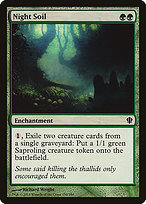

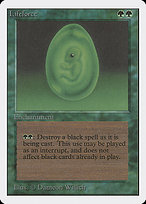

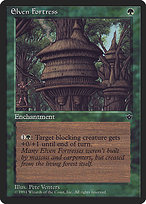

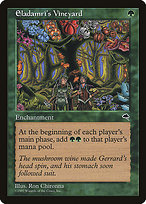

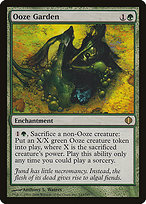

In [8]:
scm.text_sim()
scm.get_sim_cards()